In [2]:
install.packages("igraph")
install.packages("pracma")
install.packages('resample')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
library('igraph')
library('Matrix')
library('pracma')
library('resample')


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘pracma’


The following objects are masked from ‘package:Matrix’:

    expm, lu, tril, triu




In [10]:
create_transition_matrix = function (g){
    
    # WARNING: make sure your graph is connected (you might input GCC of your graph)
    
    vs = V(g)
    n = vcount(g)
    adj = as_adjacency_matrix(g)
    adj[diag(rowSums(adj) == 0)] = 1  # handle if the user is using the function for networks with isolated nodes by creating self-edges
    z = matrix(rowSums(adj, , 1))
    
    transition_matrix = adj / repmat(z, 1, n)  # normalize to get probabilities
    
    return(transition_matrix)
}

### Transition Matrix for an Undirected Network


8 x 8 sparse Matrix of class "dgCMatrix"
                                                                  
[1,] .    1.0000000 .         .         . .         .    .        
[2,] 0.25 .         0.2500000 0.2500000 . 0.2500000 .    .        
[3,] .    0.5000000 .         .         . .         .    0.5000000
[4,] .    0.2500000 .         .         . 0.2500000 0.25 0.2500000
[5,] .    .         .         .         1 .         .    .        
[6,] .    0.3333333 .         0.3333333 . .         .    0.3333333
[7,] .    .         .         1.0000000 . .         .    .        
[8,] .    .         0.3333333 0.3333333 . 0.3333333 .    .        


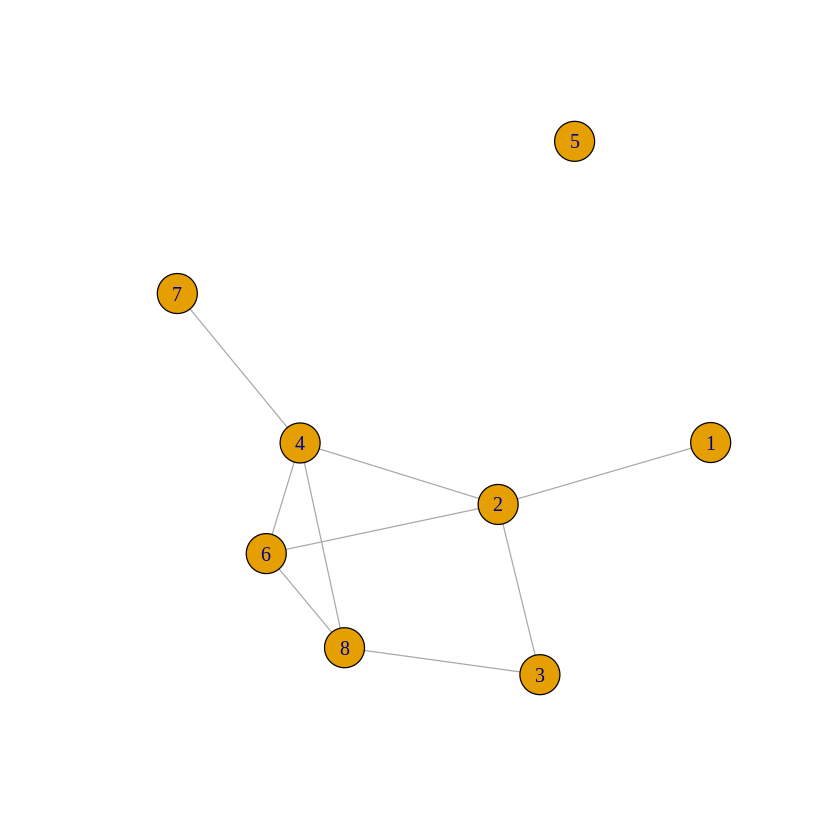

In [11]:
set.seed(0)
g = random.graph.game(8, 0.3)
plot(g)
print(create_transition_matrix(g))

### Transition Matrix for a Directed Network

8 x 8 sparse Matrix of class "dgCMatrix"
                                                                    
[1,] .    .         .    0.5000000 0.5000000 .         .         .  
[2,] 0.20 .         .    .         0.2000000 0.2000000 0.2000000 0.2
[3,] .    0.3333333 .    0.3333333 .         0.3333333 .         .  
[4,] 0.25 .         0.25 .         0.2500000 .         0.2500000 .  
[5,] .    0.5000000 .    .         .         .         .         0.5
[6,] .    0.3333333 .    .         0.3333333 .         0.3333333 .  
[7,] .    .         .    .         .         .         1.0000000 .  
[8,] .    0.2500000 0.25 .         0.2500000 .         0.2500000 .  


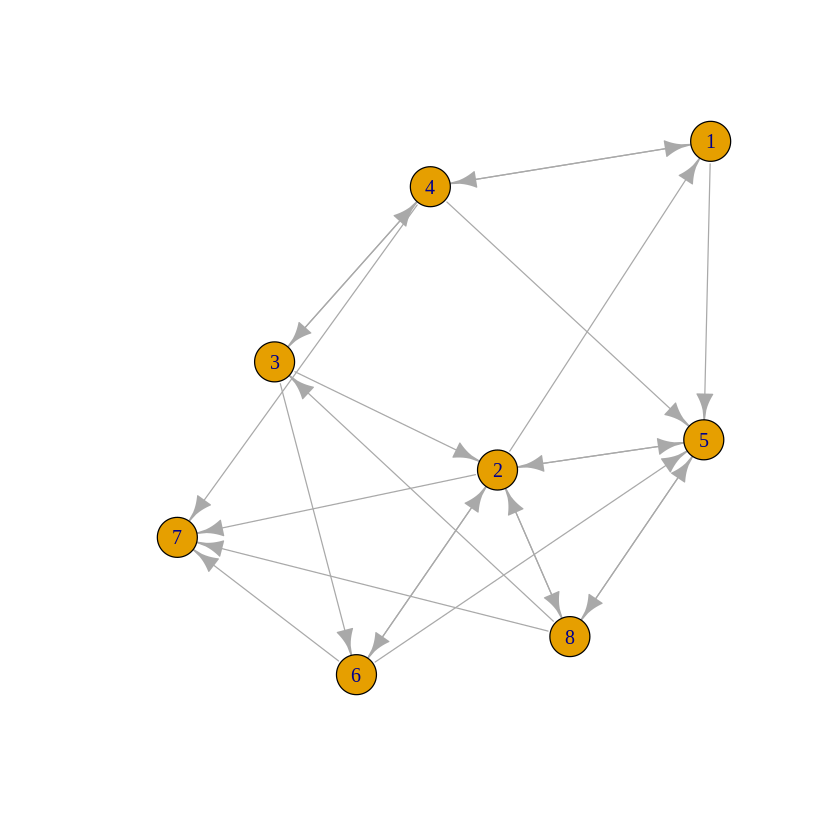

In [12]:
set.seed(1)
g = random.graph.game(8, 0.4, directed = T)
plot(g)
print(create_transition_matrix(g))

In [13]:
# random_walk = function (g, num_steps, start_node, transition_matrix = NULL){
#     if(is.null(transition_matrix))
#         transition_matrix = create_transition_matrix(g)
        
#     v = start_node
#     for(i in 1:num_steps){
#         # fprintf('Step %d: %d\n', i, v)  # COMMENT THIS
#         PMF = transition_matrix[v, ]
#         v = sample(1:vcount(g), 1, prob = PMF)        
#     }
    
#     return(v)
# }
random_walk = function (g, num_steps, start_node, transition_matrix = NULL, teleport = 0,
                       teleport_type="uniform",pr = NULL, medians=NULL){
  visited_nodes = rep(0,num_steps)
  if(is.null(transition_matrix))
    transition_matrix = create_transition_matrix(g)
  
  v = start_node
  for(i in 1:num_steps){
    #fprintf('Step %d: %d\n', i, v)  # COMMENT THIS
    if (runif(1) < teleport) {
        if (teleport_type == "uniform") {
            v = sample(1:vcount(g),1)
        }
        else if (teleport_type == "pagerank") {
            v = sample(1:vcount(g),1,prob = pr)
        }
        else if (teleport_type == "median") {
            v = sample(medians,1)
        }
        else {
            print("Error with teleport_type. Exiting code")
            quit()
        }
        
    }
    else {
        PMF = transition_matrix[v, ]
        v = sample(1:vcount(g), 1, prob = PMF)
    }
    visited_nodes[i] = v
  }
  
  return(visited_nodes)
}

In [14]:
set.seed(1)
v_last = random_walk(g, 15, 1)

# Question 1

(a)

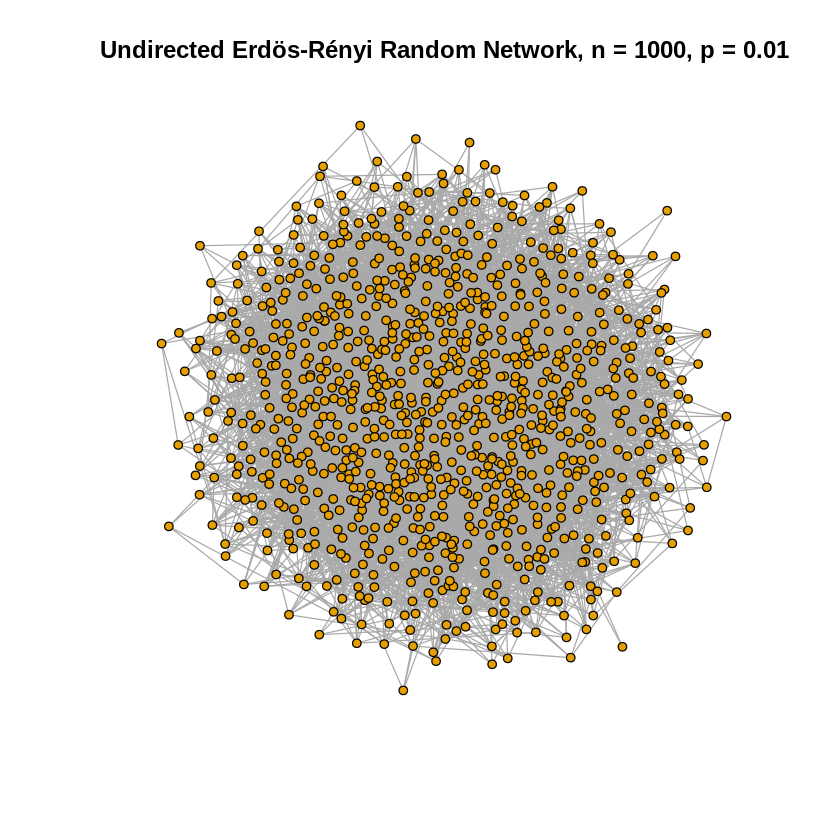

In [ ]:
|nodes <- 1000
probability <- 0.01
g <- erdos.renyi.game(n=nodes, type="gnp", p=probability, directed = FALSE)
plot(g, vertex.label="", vertex.size=3, main = "Undirected Erdös-Rényi Random Network, n = 1000, p = 0.01")

(b) and (c)

In [ ]:
errNetwork <- function(nodes, prob) {
    g <- erdos.renyi.game(n=nodes, type="gnp", p=prob, directed = FALSE)
    iteration <- 1000
    path = matrix(data=0.0, nrow=1000, ncol=100)
    degree_dis = matrix(data=0.0,nrow=1000,ncol=1)
    for (i in 1:iteration){
        if(is_connected(g)){
            gcc <- g
        }
        else{
            g.components <- clusters(g)
            idx <- which.max(g.components$csize)
            g.giant <- induced.subgraph(g, which(g.components$membership == idx))
            gcc <- g.giant
        }
        start = sample(vcount(gcc),1)
        visited = random_walk(gcc, 100, start)
        path[i,] = shortest.paths(gcc, visited, start)
        degree_dis[i,1] = degree(gcc, visited[length(visited)])  
    }
    mean_matrix = colMeans(path)
    variance_matrix = colVars(path)
    print(diameter(g))
    plot(seq(1,100,1),mean_matrix,grid(), xlab = 't', ylab = 'Shortest Distance Mean',main =paste("Average Distance vs Time with", nodes, "nodes"))
    plot(seq(1,100,1),variance_matrix,grid(), xlab = 't', ylab = 'Shortest Distance Variance',main = paste("Variance vs Time with", nodes, "nodes"))
    hist(degree_dis, ,main="Degree Distribution of the Network",xlab="Degree",ylab="Frequency")
    hist(degree(g), main="Degree Distribution for Random Walk", xlab="Degree",ylab="Frequency")
}

[1] 6


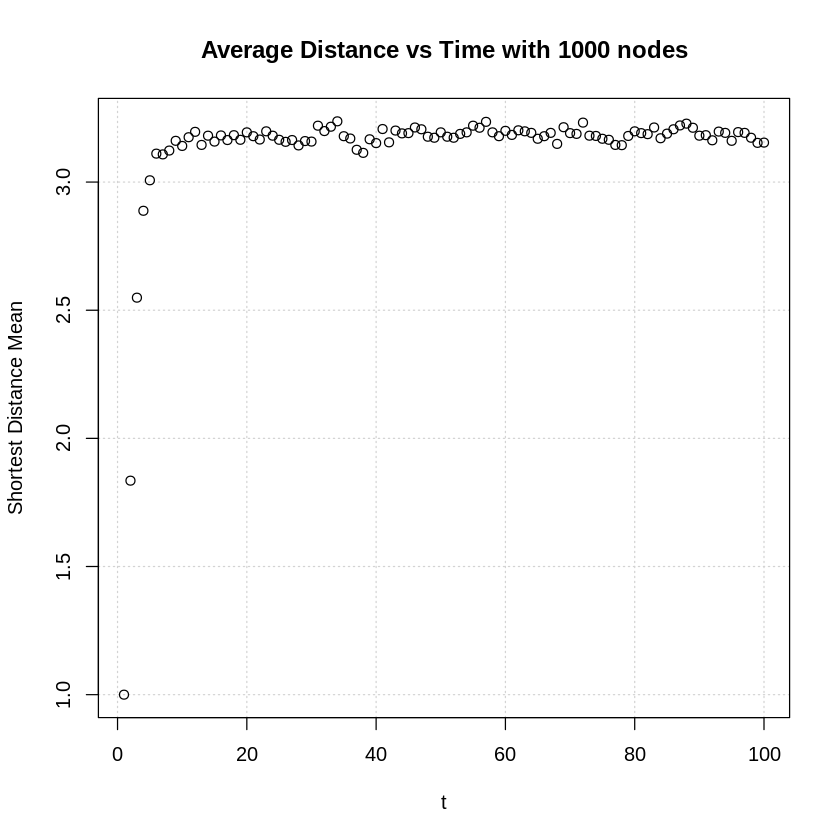

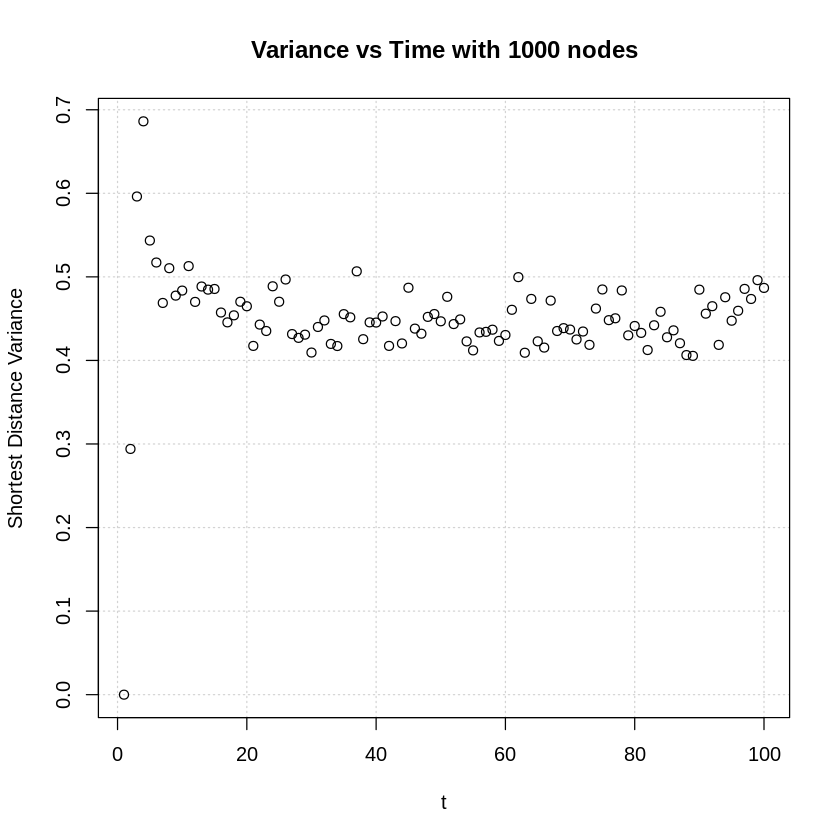

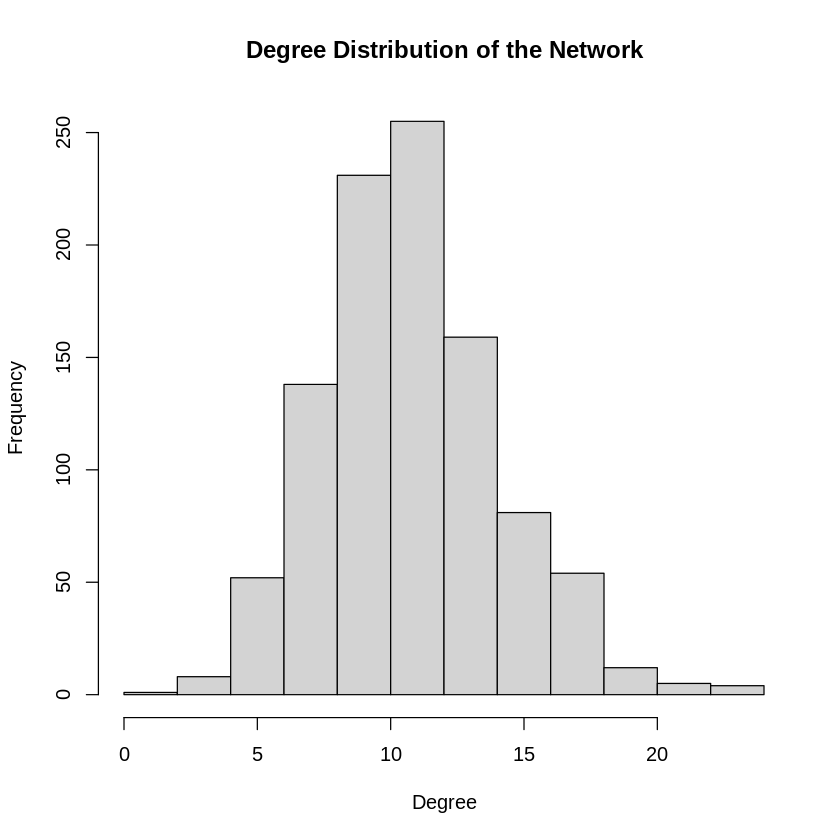

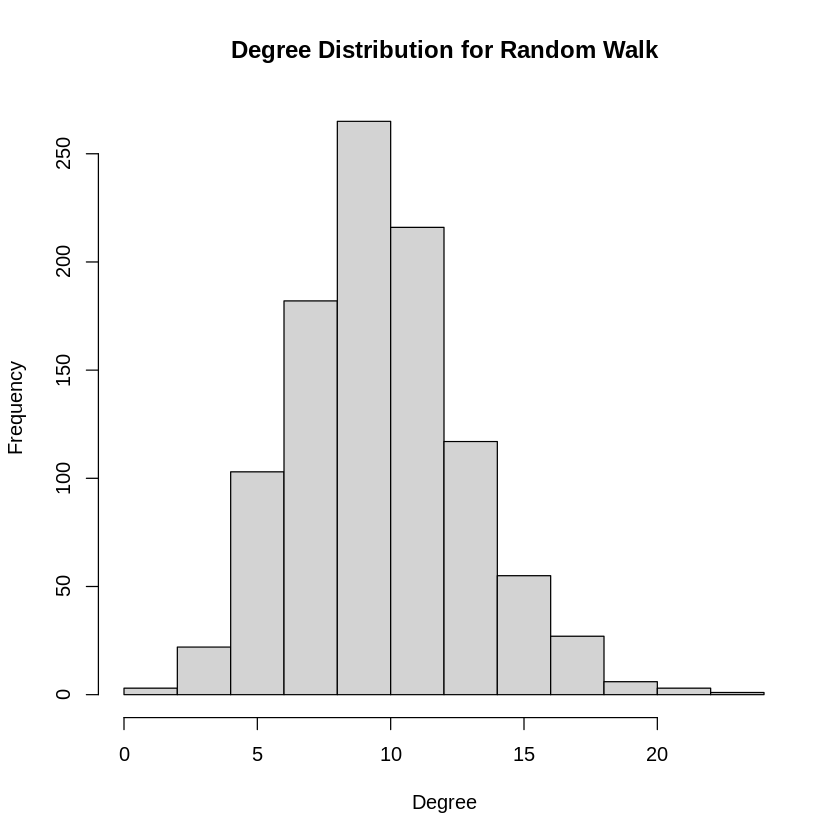

In [ ]:
errNetwork(1000, 0.01)

(d)

[1] 3


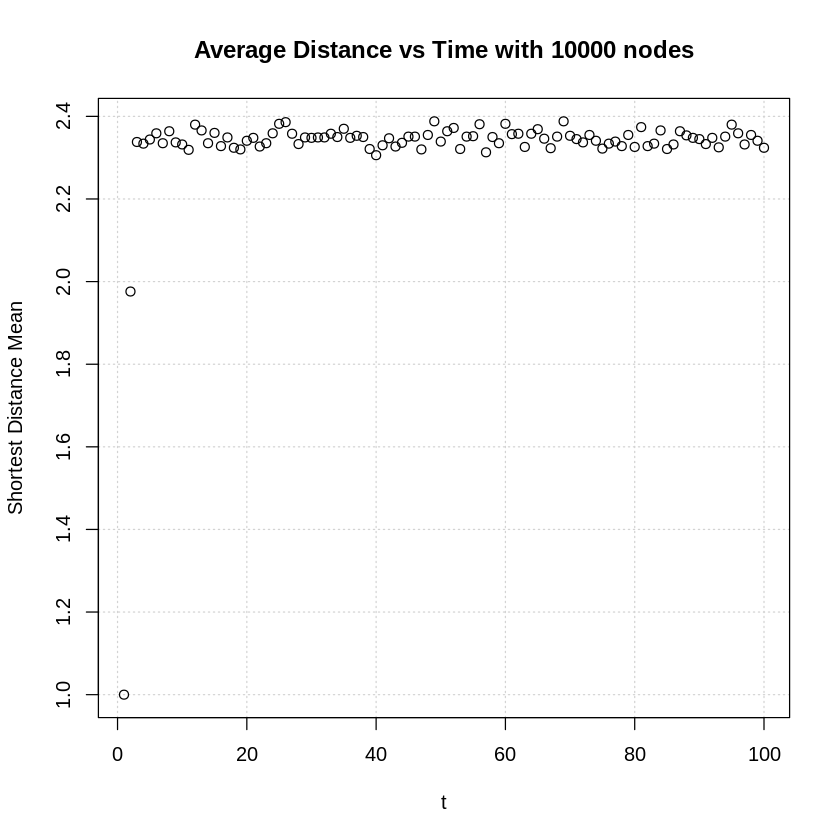

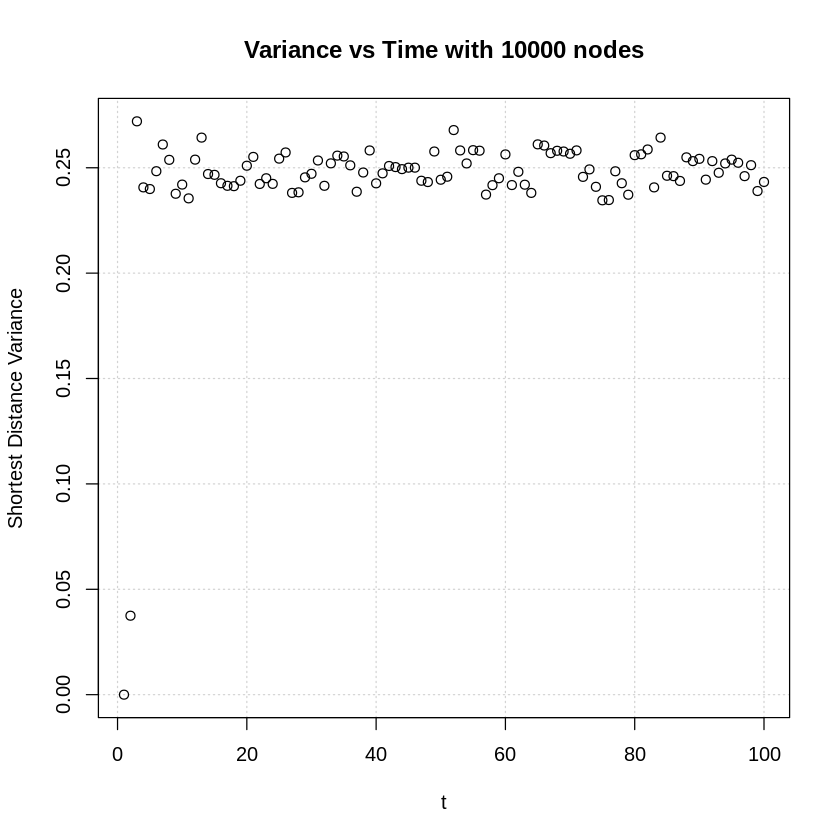

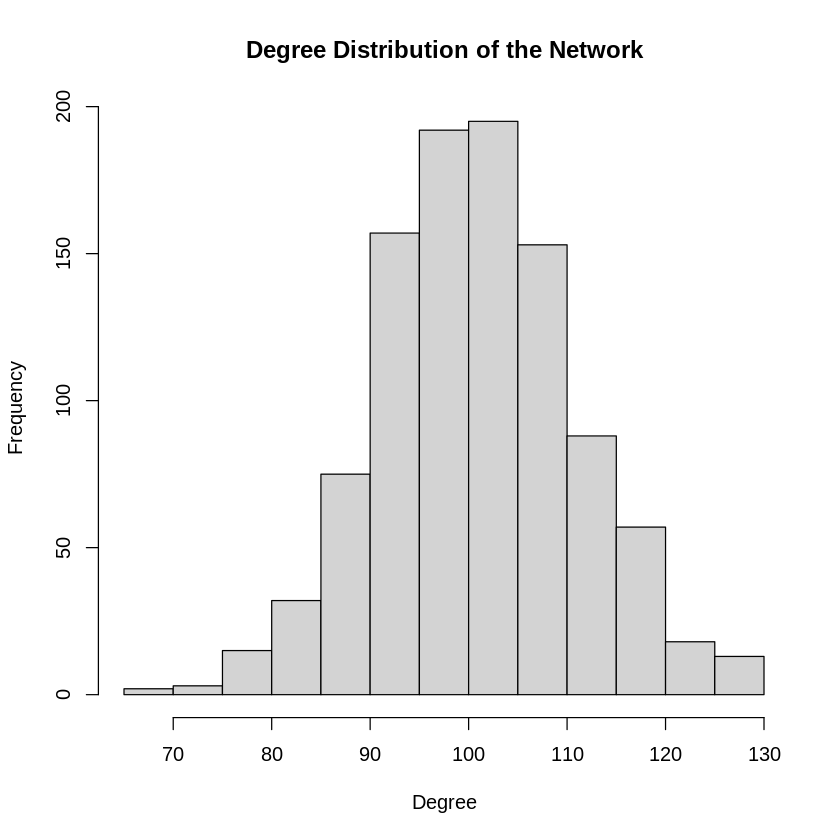

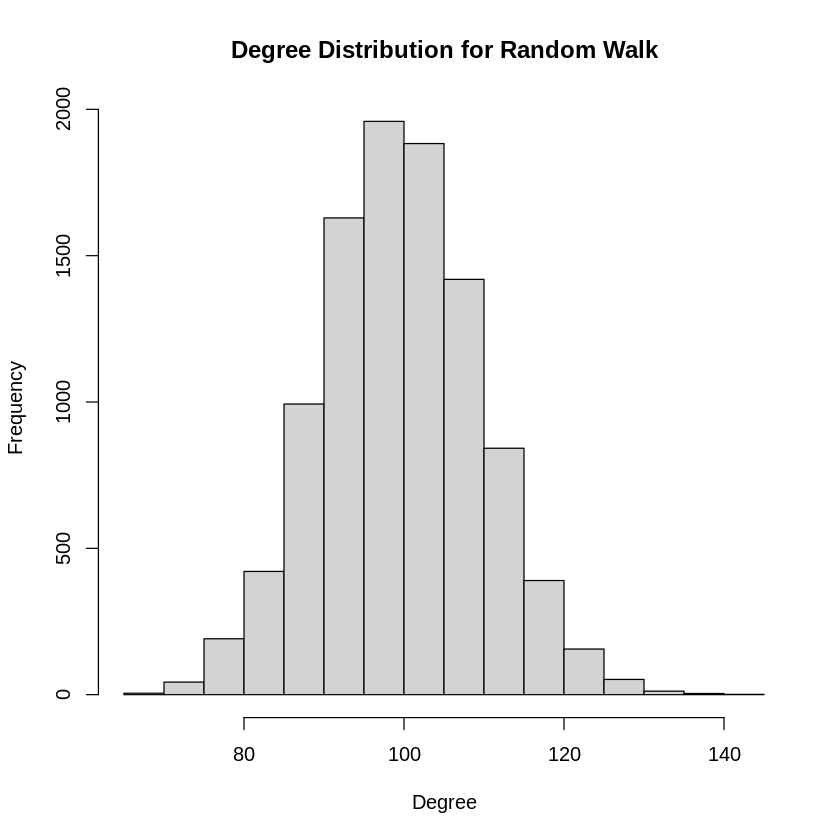

In [ ]:
errNetwork(10000, 0.01)

# Question 2

(a)

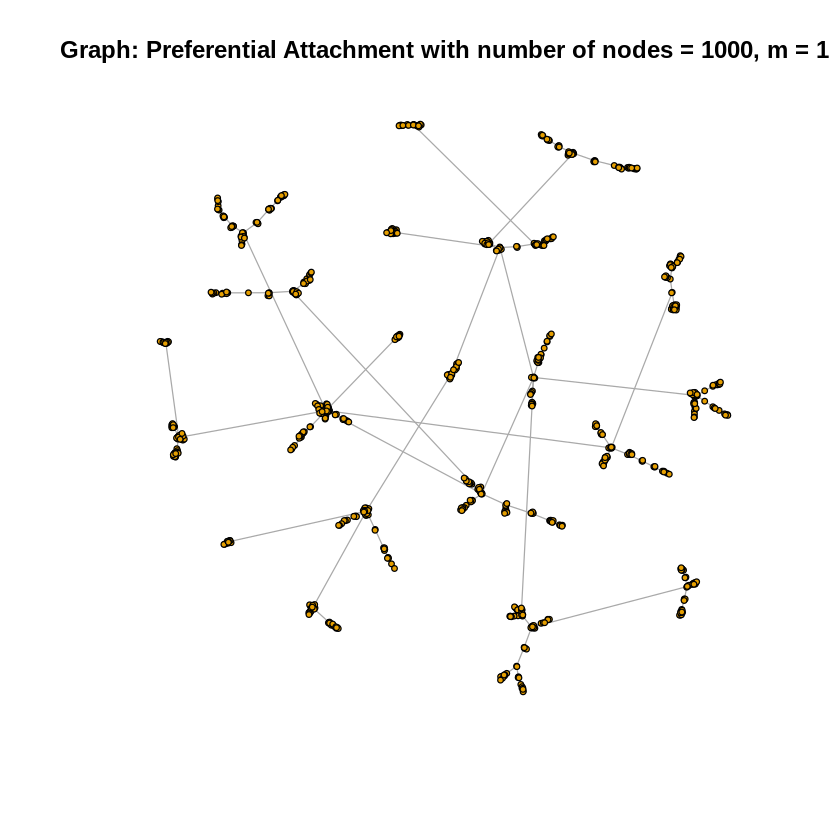

In [15]:
nodes <- 1000
m <- 1
graph <- sample_pa(nodes, m = m, directed=FALSE)
plot(graph, 
    edge.arrow.size=.1, 
    vertex.size=2, 
    vertex.label=NA,
    main=sprintf("Graph: Preferential Attachment with number of nodes = %d, m = %d", nodes, m)
)

(b) and (c)

In [16]:
errNetworkPA <- function(nodes, m) {
    g <- sample_pa(nodes, m = m, directed=FALSE)
    iteration <- 1000
    path <- matrix(data=0.0, nrow=1000, ncol=100)
    degree_dis <- matrix(data=0.0,nrow=1000,ncol=1)
    for (i in 1:iteration){
        if(is_connected(g)){
            gcc <- g
        }
        else{
            g.components <- clusters(g)
            idx <- which.max(g.components$csize)
            g.giant <- induced.subgraph(g, which(g.components$membership == idx))
            gcc <- g.giant
        }
        start <- sample(vcount(gcc),1)
        visited <- random_walk(gcc, 100, start)
        path[i,] <- shortest.paths(gcc, visited, start)
        degree_dis[i,1] <- degree(gcc, visited[length(visited)])  
    }
    mean_matrix = colMeans(path)
    variance_matrix = colVars(path)
    print(diameter(g))
    plot(seq(1,100,1),mean_matrix,grid(), xlab = 't', ylab = 'Shortest Distance Mean',main =paste("Average Distance vs Time with", nodes, "nodes"))
    plot(seq(1,100,1),variance_matrix,grid(), xlab = 't', ylab = 'Shortest Distance Variance',main = paste("Variance vs Time with", nodes, "nodes"))
    hist(degree_dis, ,main="Degree Distribution of the Network",xlab="Degree",ylab="Frequency")
    hist(degree(g), main="Degree Distribution for Random Walk", xlab="Degree",ylab="Frequency")
}

[1] 18
[1] 18


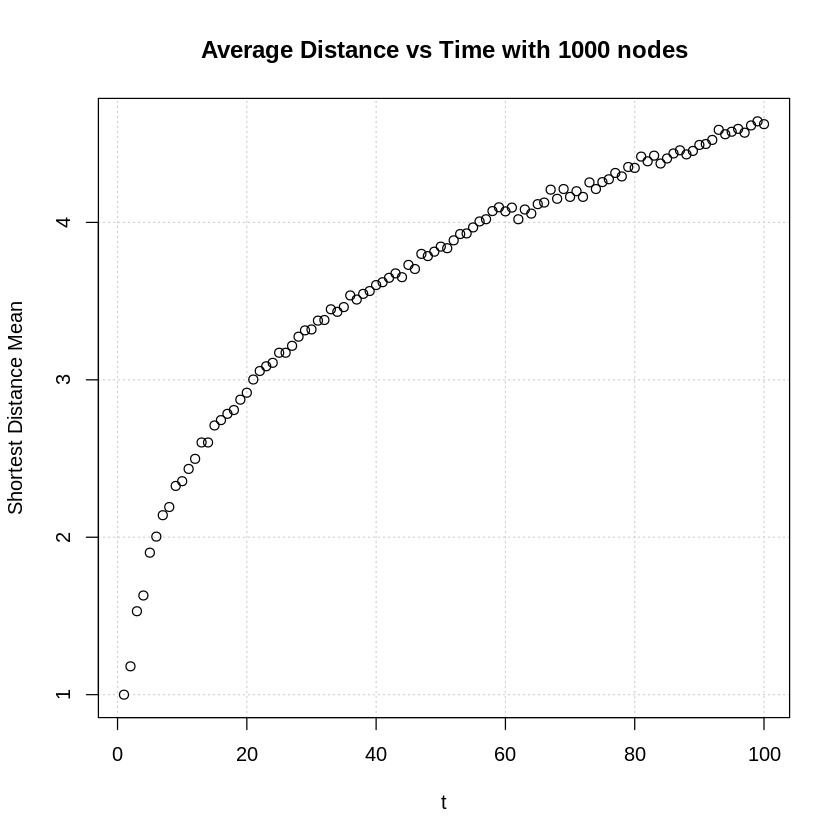

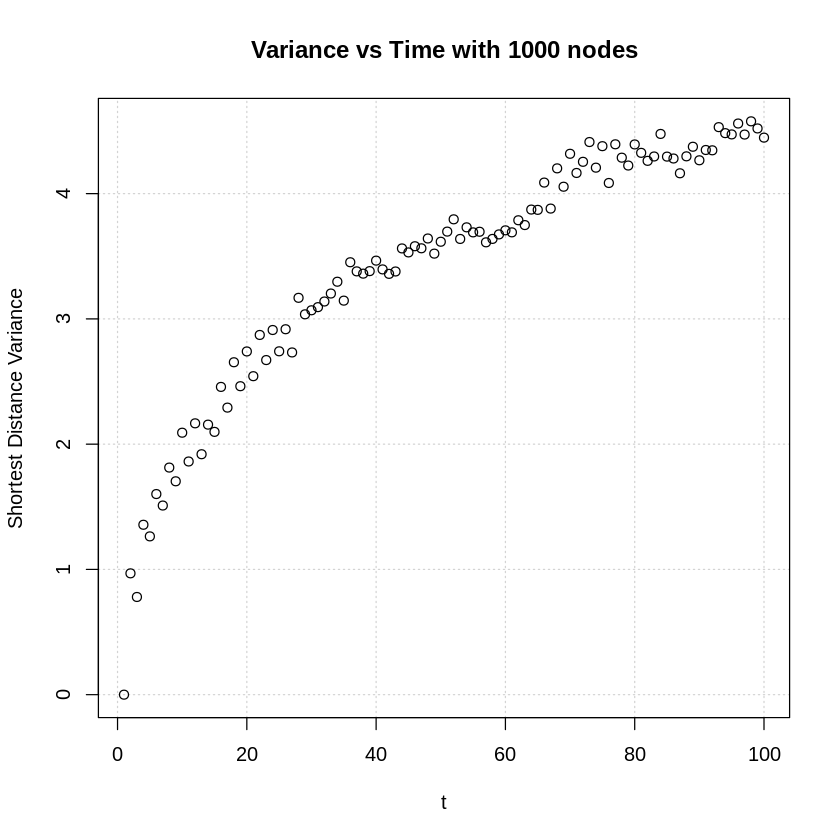

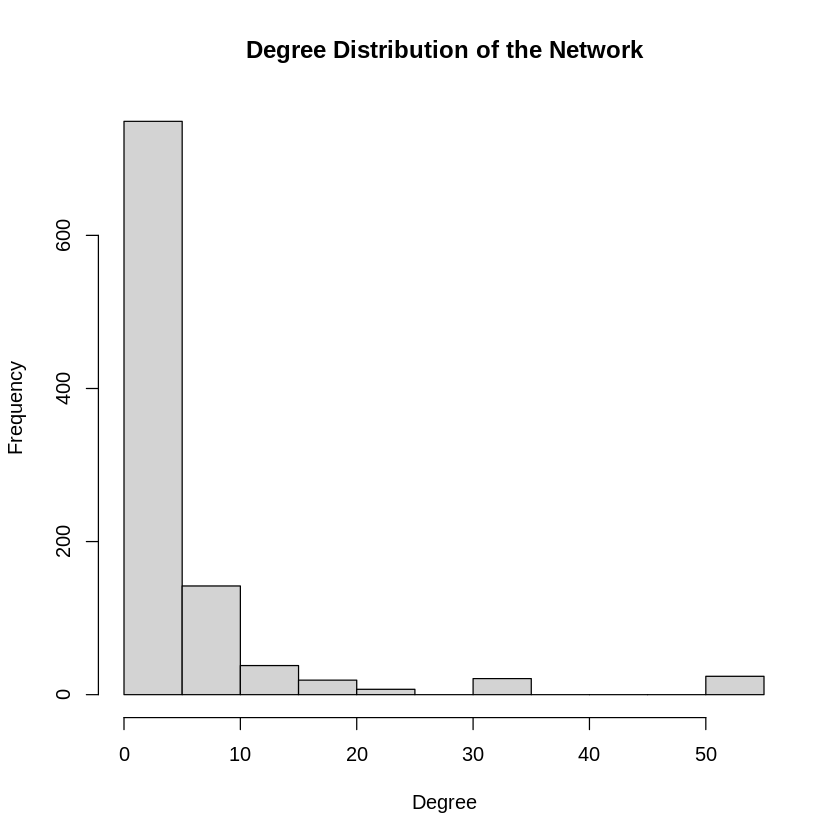

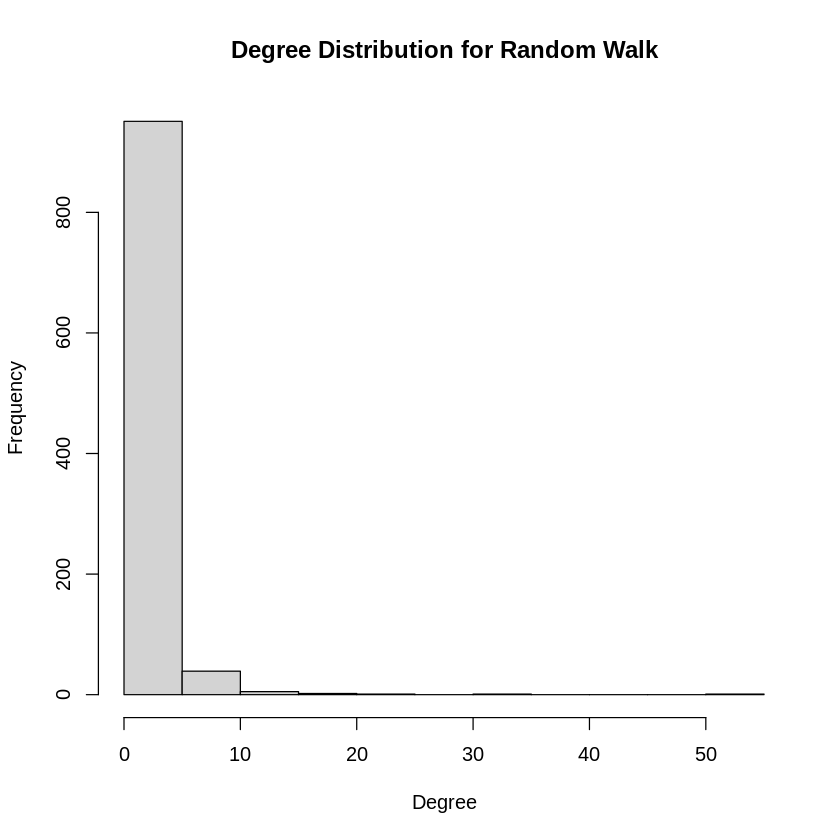

In [ ]:
errNetworkPA(1000, 1)

(d)

[1] 12
[1] 12


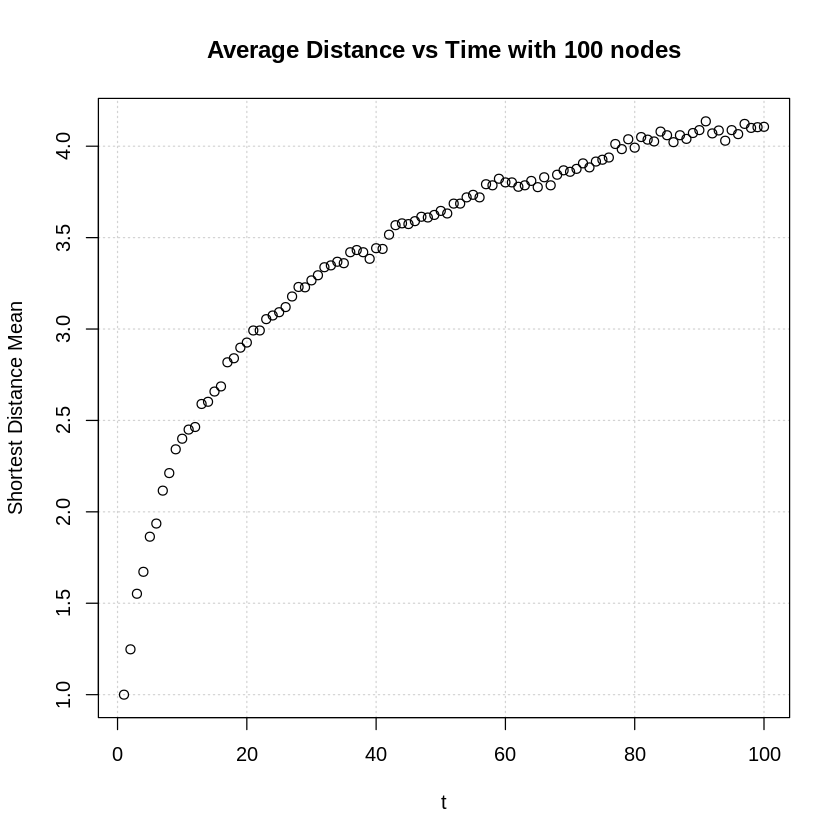

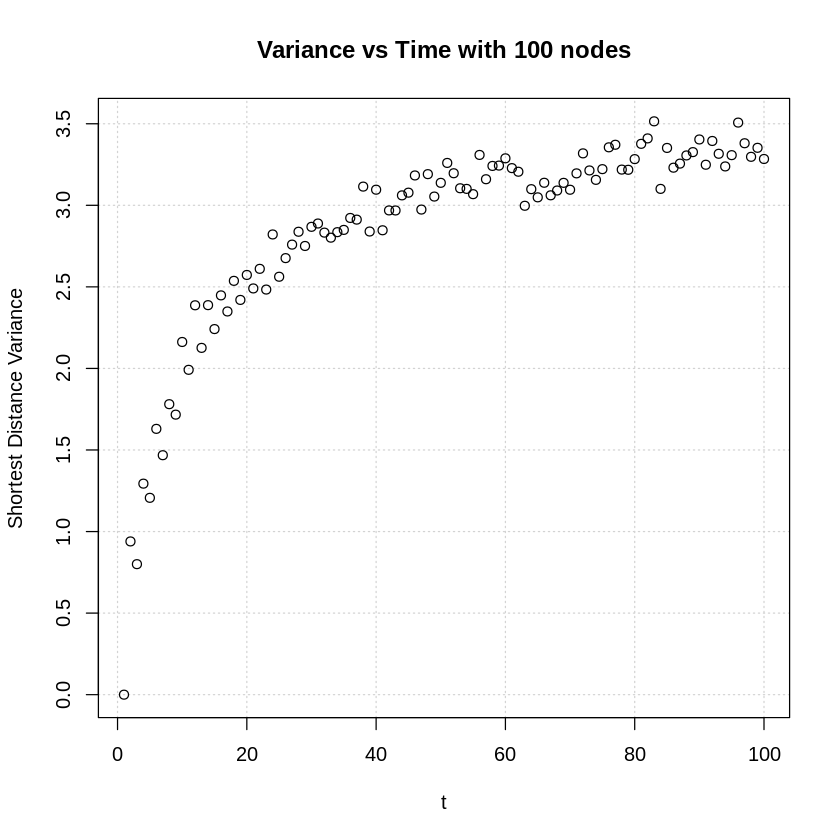

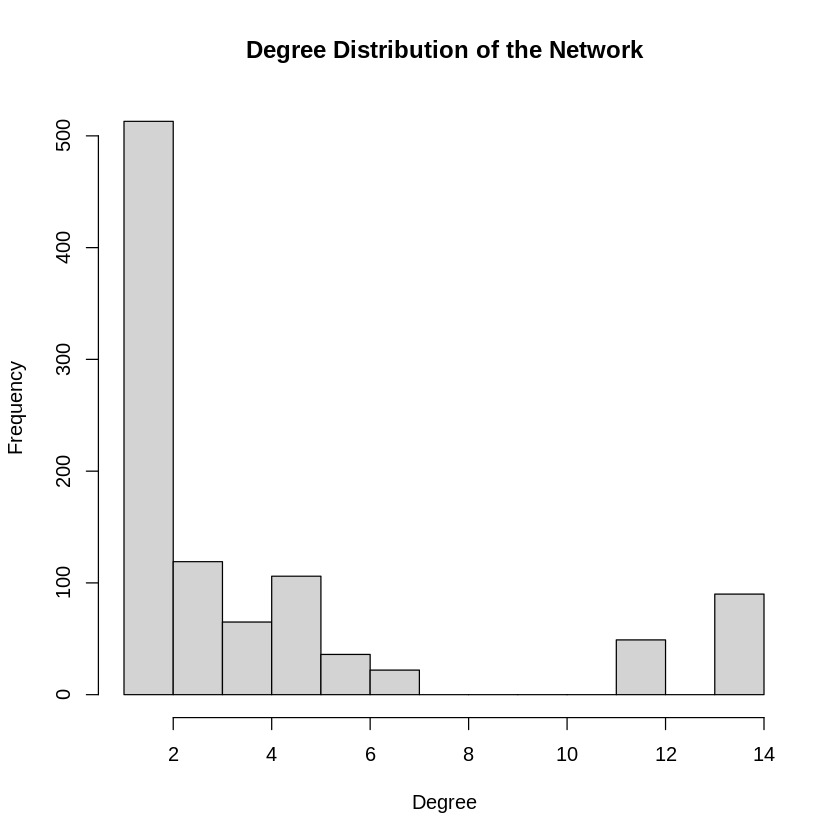

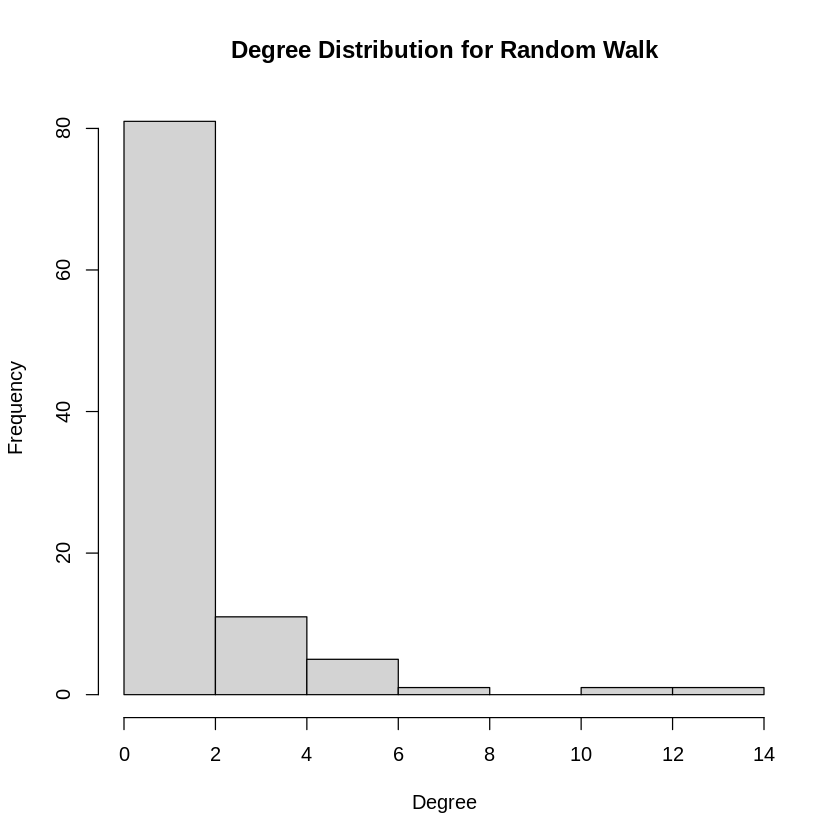

In [ ]:
errNetworkPA(100, 1)

[1] 30


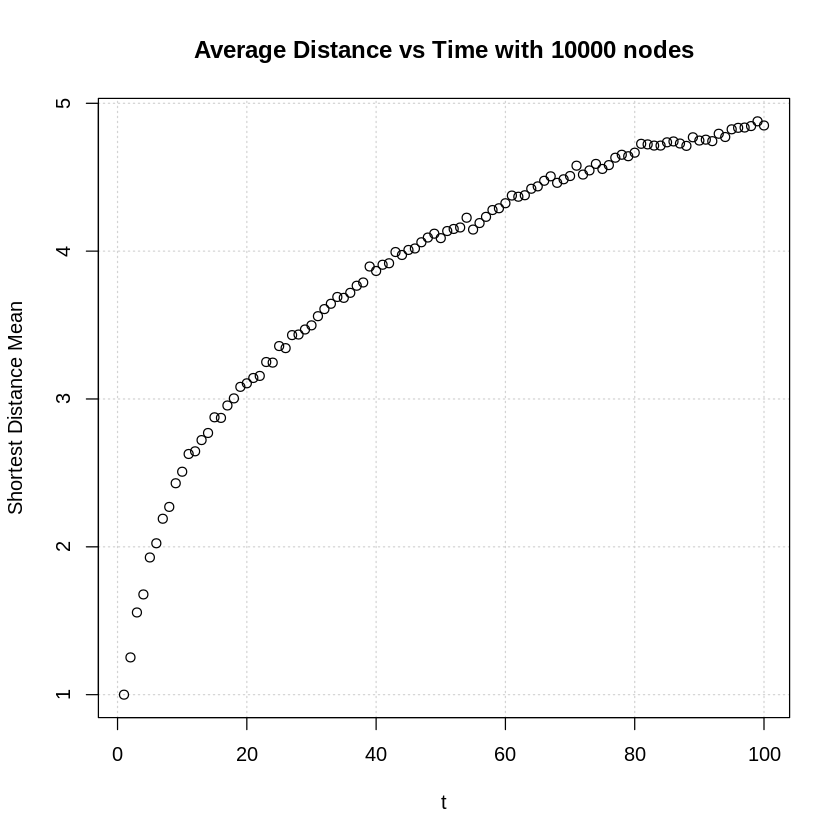

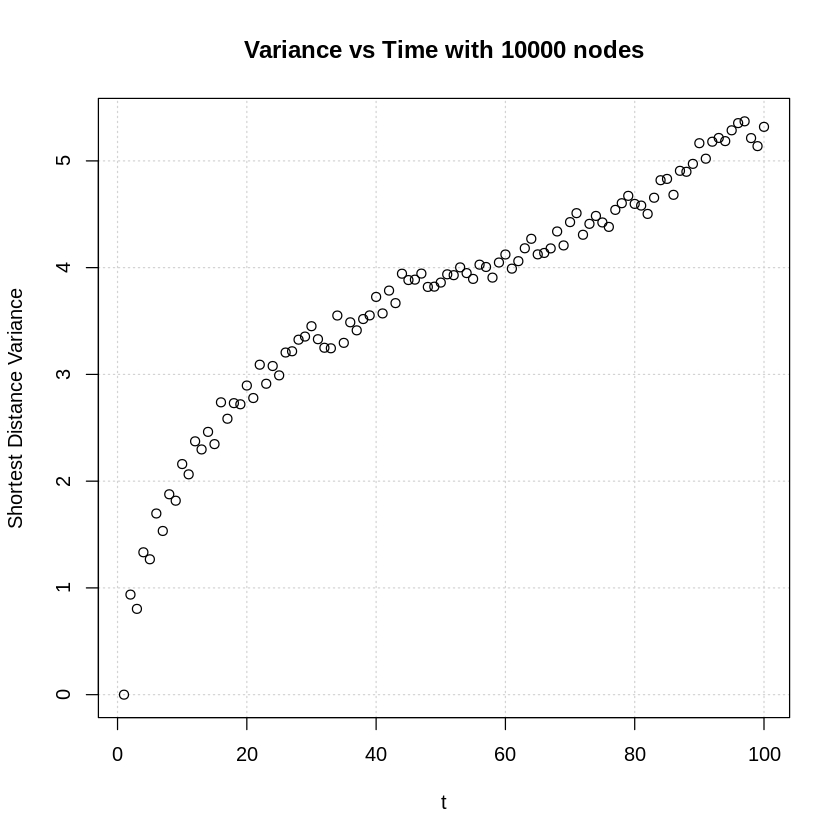

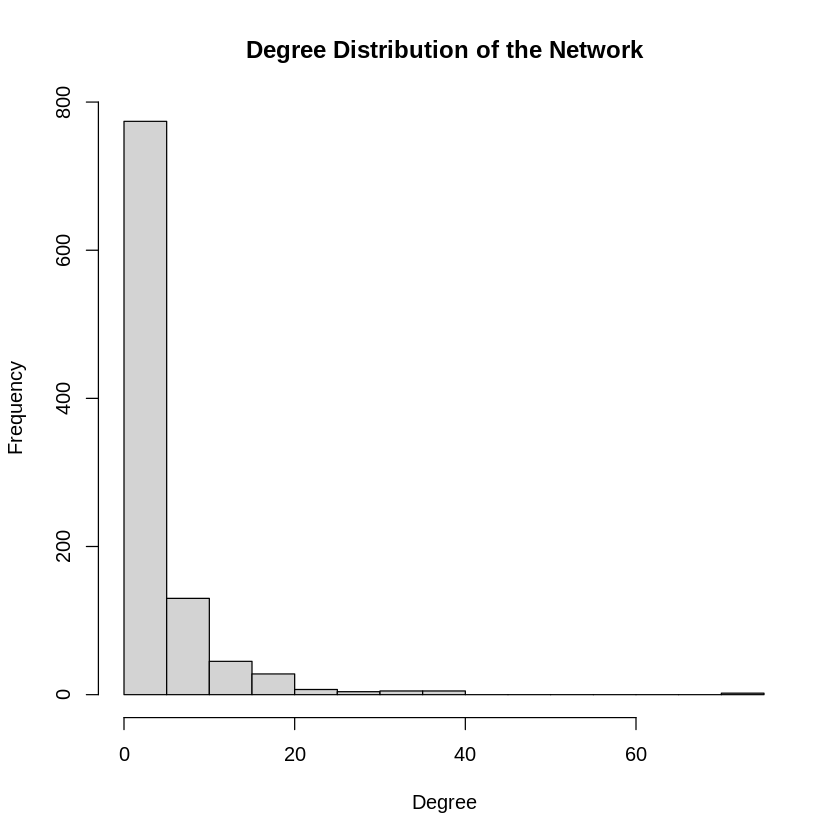

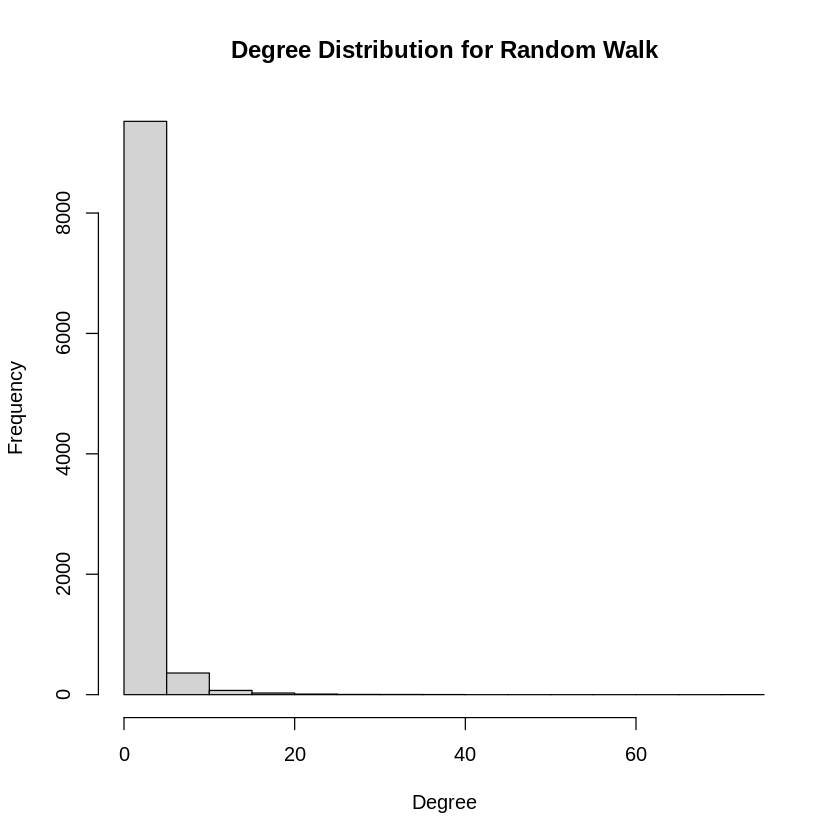

In [17]:
errNetworkPA(10000, 1)